In [46]:
import pandas as pd
from Environments import TrainingEnv
from Environments import TestingEnv
import matplotlib.pyplot as plt

In [47]:
from stable_baselines3.common.env_checker import check_env

In [48]:
training_data = pd.read_csv('./KO_scaled/Training.csv')
training_data.drop(labels=['Date'], axis=1, inplace=True)
training_data.describe()

,Close,RSI,MACD,MACD Percentage,Volume Oscillator,CV,Scaled RSI,Pct Change
count,3514.000000,3514.000000,3514.000000,3514.000000,3514.000000,3514.000000,3.514000e+03,3514.000000
mean,23.625804,52.120686,0.056143,-0.008491,0.046023,0.208813,1.796090e-02,-0.021582
std,8.516981,13.738275,0.212338,0.773836,0.814792,0.849503,7.049614e-01,0.885417
min,11.232055,6.065151,-0.718191,-3.000000,-2.173852,-1.074975,-2.345318e+00,-3.000000
25%,15.587463,42.380796,-0.067994,-0.494597,-0.494461,-0.410432,-4.818287e-01,-0.516599
50%,23.085698,51.770664,0.051301,0.000000,0.000000,0.000000,-1.999811e-16,0.000000
75%,30.923383,61.868777,0.200633,0.505403,0.505539,0.589568,5.181713e-01,0.483401
max,41.838058,93.843095,0.878629,2.503254,3.000000,3.000000,2.158891e+00,3.000000


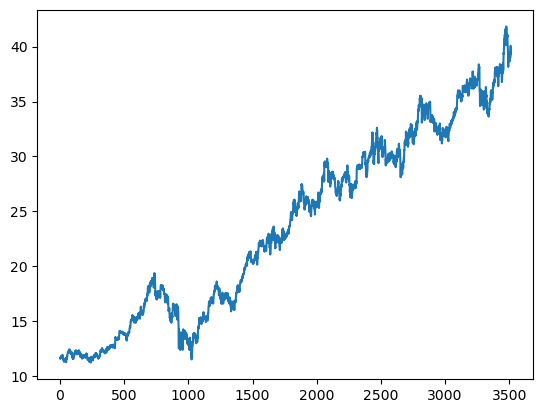

In [49]:
plt.plot(training_data['Close'])

In [50]:
validation_data = pd.read_csv('./KO_scaled/Validation.csv')
validation_data.drop(labels=['Date'], axis=1, inplace=True)
validation_data.describe()

,Close,RSI,MACD,MACD Percentage,Volume Oscillator,CV,Scaled RSI,Pct Change
count,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000
mean,45.532374,53.630474,0.142160,0.095683,0.031893,0.463230,0.095434,0.044748
std,4.288323,13.386466,0.644446,0.924366,0.959961,1.039761,0.686909,1.065494
min,32.449383,21.079795,-3.941018,-3.000000,-2.438497,-0.891317,-1.574861,-3.000000
25%,42.350840,43.028172,-0.092946,-0.376772,-0.612383,-0.275699,-0.448609,-0.485170
50%,45.744759,53.153814,0.298442,0.329410,-0.070455,0.124877,0.070974,0.104404
75%,48.803635,64.129671,0.510291,0.715121,0.539852,0.939791,0.634186,0.670502
max,56.089264,94.759103,1.131193,1.575465,3.000000,3.000000,2.205895,3.000000


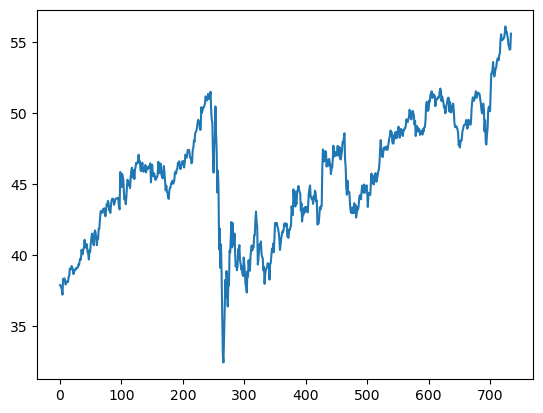

In [51]:
plt.plot(validation_data['Close'])

In [52]:
testing_data = pd.read_csv('./KO_scaled/Testing.csv')
testing_data.drop(labels=['Date'], axis=1, inplace=True)
testing_data.describe()

,Close,RSI,MACD,MACD Percentage,Volume Oscillator,CV,Scaled RSI,Pct Change
count,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000
mean,59.344009,49.802065,0.061433,-0.136073,0.011308,0.300555,-0.101016,-0.071454
std,4.159435,13.886524,0.666224,0.934858,0.832689,0.803276,0.712569,0.917845
min,50.426121,6.053355,-1.825078,-2.747690,-1.754180,-0.844844,-2.345923,-3.000000
25%,56.870604,40.082673,-0.397245,-0.765298,-0.640867,-0.283778,-0.599754,-0.640253
50%,58.472458,50.428820,0.168105,0.026646,-0.017603,0.106937,-0.068855,-0.077785
75%,60.971121,59.552489,0.509968,0.515237,0.596467,0.719200,0.399314,0.533372
max,71.967041,92.557738,1.555504,1.716960,3.000000,3.000000,2.092935,3.000000


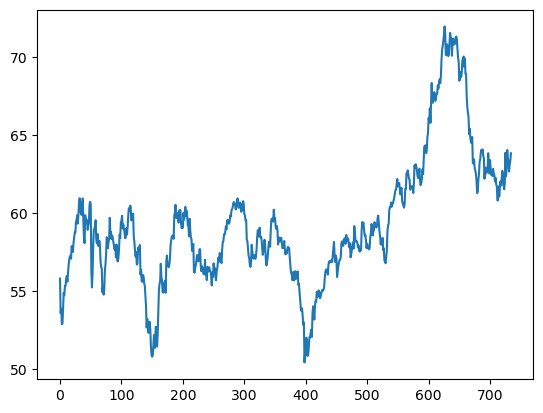

In [53]:
plt.plot(testing_data['Close'])

In [54]:
episode_length = len(testing_data)

training_env = TrainingEnv(training_data, episode_length=episode_length)
check_env(training_env, warn=True)
validation_env = TestingEnv(validation_data)
check_env(validation_env, warn=True)
testing_env = TestingEnv(testing_data)
check_env(testing_env, warn=True)

In [55]:
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback

class TensorboardCallback(BaseCallback):
    def __init__(self, env, eval_freq, verbose=0):
        super().__init__(verbose)
        self.env = env
        self.eval_freq = eval_freq

    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            obs, info = self.env.reset()
            rewards = []
            while True:
                action, _states = self.model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = self.env.step(action)
                rewards.append(reward)
                if terminated or truncated:
                    break
            self.logger.record("Mean Validation Set Reward", np.array(rewards).mean())
            self.logger.record("Cumulative Validation Set Reward", np.array(rewards).sum())
            self.logger.record("Maximum Validation Set Reward", np.max(rewards))
            self.logger.record("Minimum Validation Set Reward", np.min(rewards))
            self.logger.record("Gamma", self.model.gamma)
            self.logger.record("Exploration Fraction", self.model.exploration_fraction)
            self.logger.record("Buffer Size", self.model.buffer_size)
        return True


In [ ]:
# from stable_baselines3 import DQN

# tensorboard_callback = TensorboardCallback(validation_env, episode_length * 10)
# model = DQN("MlpPolicy", training_env, buffer_size=10_000, seed=6, exploration_fraction=0.6, tensorboard_log="./tensorboard", learning_rate=0.0001)
# # model.learn(500*1000, callback=eval_callback)
# model.learn(4_000_000, callback = tensorboard_callback)

KeyboardInterrupt: 

In [ ]:
from stable_baselines3 import DQN
import optuna

max_reward = -1000

def objective(trial: optuna.Study) -> float:
    global max_reward
    learning_rate = trial.suggest_float('learning rate', 0.0001, 0.1)
    gamma = trial.suggest_float('gamma', 0.9, 0.999)
    exploration_fraction = trial.suggest_float('exploration fraction', 0.5, 0.8)
    buffer_size = trial.suggest_int('buffer size', 1_000, 100_000)


    model = DQN("MlpPolicy", training_env, learning_rate=learning_rate, 
                buffer_size=buffer_size, gamma=gamma, exploration_fraction=exploration_fraction, seed=10,
                tensorboard_log="./KO_Hyperparameter_Tuning")
    
    tensorboard_callback = TensorboardCallback(validation_env, episode_length * 10)


    model.learn(4_000_000, callback=tensorboard_callback)


    rewards = []
    obs, info = validation_env.reset()
    while True:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = validation_env.step(action)
        rewards.append(reward)
        if terminated or truncated:
            break

    cumulative_reward = np.array(rewards).sum()
    if cumulative_reward > max_reward:
        model.save("KO_agent")
        max_reward = cumulative_reward


    return -cumulative_reward

    


study = optuna.create_study()
study.optimize(objective, n_trials = 15, show_progress_bar=True)

print(f'Best Parameters: {study.best_params}')
print(f'Best value: {study.best_value}')

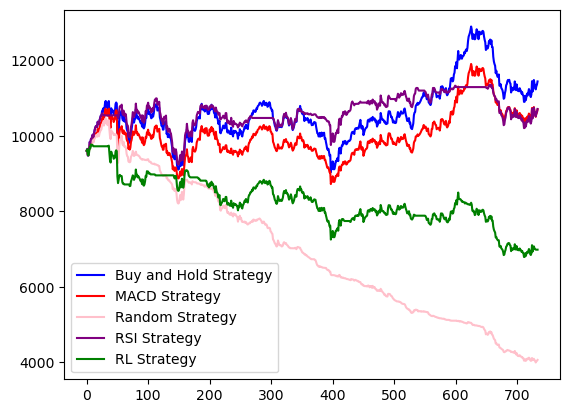

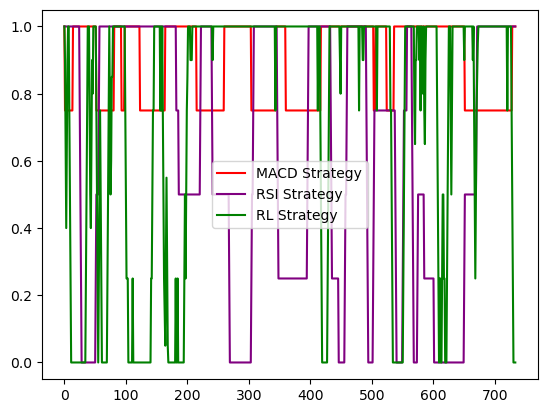

In [32]:
buy_and_hold_strategy_value = []
MACD_asset_allocations = []
MACD_strategy_value = []
random_asset_allocations = []
RSI_asset_alloctions =[]
RL_strategy_value = []
RL_asset_allocations = []

obs, info = testing_env.reset()
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = testing_env.step(action)
    RL_strategy_value.append(info['Portfolio Value'])
    RL_asset_allocations.append(info['Asset Allocation'])
    if terminated or truncated:
        break
    
prev_MACD = -1
obs, info = testing_env.reset()
while True:

    # buy 25% if MACD crosses above zero line, sell 25% if MACD crosses below zero line, otherwise do nothing
    if info['MACD'] > 0 and prev_MACD < 0:
        action = 4
        prev_MACD = info['MACD']
    elif info['MACD'] < 0 and prev_MACD > 0:
        action = 0
        prev_MACD = info['MACD']
    else:
        action = 2
    obs, reward, terminated, truncated, info = testing_env.step(action)
    MACD_strategy_value.append(info['Portfolio Value'])
    buy_and_hold_strategy_value.append(info['Buy and Hold Value'])
    MACD_asset_allocations.append(info['Asset Allocation'])
    if terminated or truncated:
        break

random_strategy_value = []
obs, info = testing_env.reset(seed=10)
while True:

    action = testing_env.action_space.sample()
    obs, reward, terminated, truncated, info = testing_env.step(action)
    random_strategy_value.append(info['Portfolio Value'])
    random_asset_allocations.append(info['Asset Allocation'])
    if terminated or truncated:
        break

RSI_strategy_value = []
obs, info = testing_env.reset()
while True:

    # sell 25% if RSI is above 70, buy 25% if RSI is below 30, otherwise do nothing
    # RSI typically uses 30 and 70 for thresholds
    if info['RSI'] < 30:
        action = 4
    elif info['RSI'] > 70:
        action = 0
    else:
        action = 2
    obs, reward, terminated, truncated, info = testing_env.step(action)
    RSI_strategy_value.append(info['Portfolio Value'])
    RSI_asset_alloctions.append(info['Asset Allocation'])
    if terminated or truncated:
        break

plt.figure()
plt.plot(buy_and_hold_strategy_value, "blue", label="Buy and Hold Strategy")
plt.plot(MACD_strategy_value, "red", label="MACD Strategy")
plt.plot(random_strategy_value, "pink", label="Random Strategy")
plt.plot(RSI_strategy_value, "purple", label="RSI Strategy")
plt.plot(RL_strategy_value, "green", label="RL Strategy")
plt.legend()

plt.figure()
plt.plot(MACD_asset_allocations, "red", label="MACD Strategy")
# plt.plot(random_asset_allocations, "pink", label="Random Strategy")
plt.plot(RSI_asset_alloctions, "purple", label="RSI Strategy")
plt.plot(RL_asset_allocations, "green", label="RL Strategy")
plt.legend()
plt.show()